# TP 3 Cifar 100 Guardia, Labrador y Saracco

 CIFAR-100 es un subconjunto etiquetado de imágenes diminutas. El conjunto de datos constan de 50000 imágenes en color de 32x32. El mismo, comprende 100 clases que contienen 500 imágenes cada una.

 Las 100 clases del CIFAR-100 se agrupan en 20 superclases. Cada imagen está asociada con una etiqueta "fina" (la clase a la que está asociada) y una etiqueta "gruesa" (la superclase con la que está asociada)

# Importar librerías y montar drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd drive
%cd Shareddrives
%cd Redes neuronales

Mounted at /content/drive
/content/drive
/content/drive/Shareddrives
/content/drive/Shareddrives/Redes neuronales


In [ ]:
%cd TP3/

/content/drive/Shareddrives/Redes neuronales/TP3


# Importar Datos

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (15).json


{'kaggle.json': b'{"username":"camilasolguardia","key":"08502a67f702520e8a9c44c2da543bd7"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c cnn-itba-2021-q2

X_test.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
X_train.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
y_train.npy: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip X_train.npy.zip
!unzip y_train.npy.zip
!unzip X_test.npy.zip

Archive:  X_train.npy.zip
replace X_train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: X_train.npy             
unzip:  cannot find or open y_train.npy.zip, y_train.npy.zip.zip or y_train.npy.zip.ZIP.
Archive:  X_test.npy.zip
replace X_test.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: X_test.npy              


In [ ]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("X_test.npy")

# Preprocesamiento

Separamos los datos en test y validación con una proporción de 80/20

In [ ]:
valid_porcentage = 0.2
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=valid_porcentage, random_state=42, stratify=y_train)

Normalizamos los datos dividiendo por 255. Haciendo to_categorical a las variables y_train e y_val, se generan matrices de clases binarias

In [ ]:
x_train_norm = x_train/255
x_val_norm = x_val/255

x_test_norm = x_test/255

y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 100

Hacemos Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator( 
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,  
        vertical_flip = False
        )
train_datagen.fit(x_train_norm)

# CNN

Definimos el modelo

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(100, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

Entrenamos el modelo

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.6, min_denta=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
        
history = model.fit(x_train_norm, y_train, epochs=100, validation_data = (x_val_norm, y_val), callbacks=[reduce_lr, es])

Epoch 1/100
1250/1250 [==============================] - 35s 27ms/step - loss: 3.9376 - accuracy: 0.1130 - val_loss: 3.3993 - val_accuracy: 0.1810 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 35s 28ms/step - loss: 3.2150 - accuracy: 0.2137 - val_loss: 2.8980 - val_accuracy: 0.2748 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.8263 - accuracy: 0.2879 - val_loss: 2.5537 - val_accuracy: 0.3466 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.5875 - accuracy: 0.3350 - val_loss: 2.2864 - val_accuracy: 0.3978 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.4226 - accuracy: 0.3681 - val_loss: 2.3142 - val_accuracy: 0.3949 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.2759 - accuracy: 0.3957 - val_loss: 2.1516 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 7/100
1250/1250 [=================

Visualizamos la loss y el accuracy para valid y train

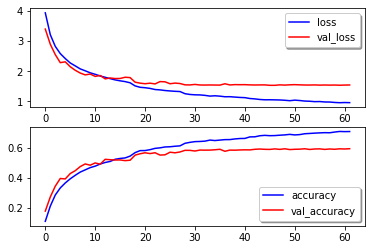

In [ ]:
_, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='loss')
ax[0].plot(history.history['val_loss'], color='r', label='val_loss')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='val_accuracy')
legend = ax[1].legend(loc='best', shadow=True)

Utlizando el modelo creado, se realiza la predicción

In [ ]:
prediction = model.predict(x_test_norm)
y_test = prediction.argmax(axis=1)
df = pd.DataFrame(data=y_test,columns=["label"])
df.index.name="Id"
df.head()

,label
Id,
0,68
1,33
2,55
3,51
4,71


In [ ]:
y_test

array([72, 33, 55, ..., 51, 42, 70])

Se pasa a un csv para realizar el submit

In [ ]:
df.to_csv("Test_40.csv")


72


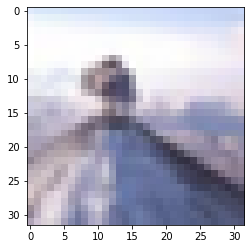

33


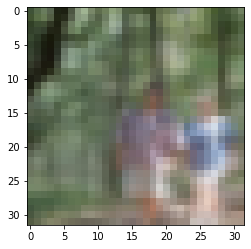

55


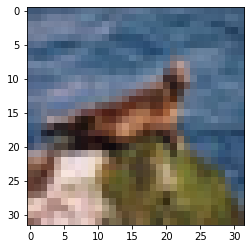

51


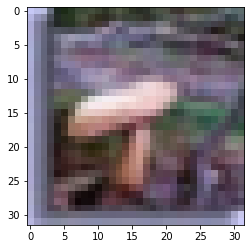

71


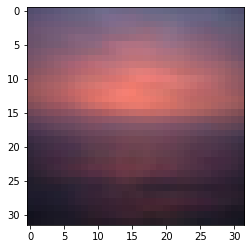

6


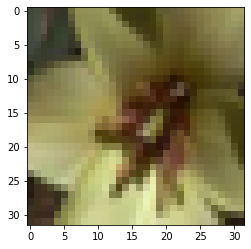

27


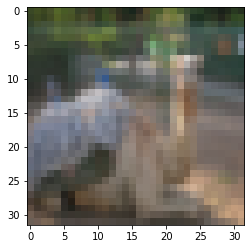

74


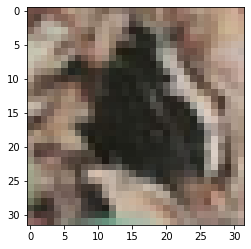

23


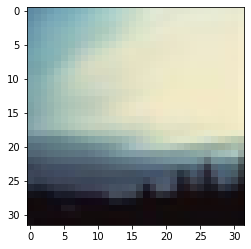

57


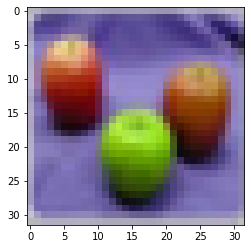

12


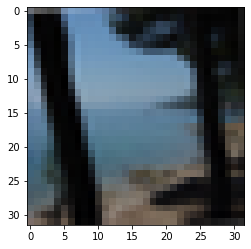

75


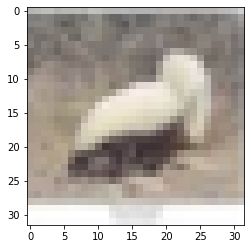

81


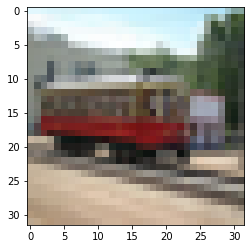

69


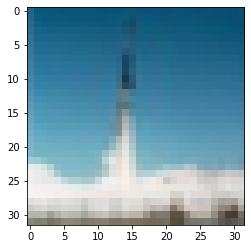

40


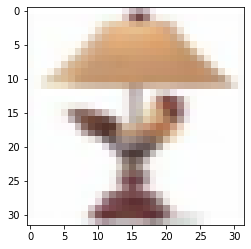

43


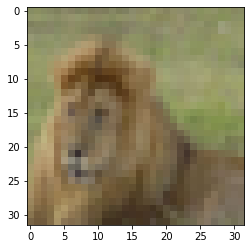

92


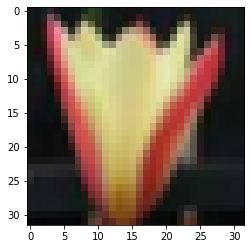

97


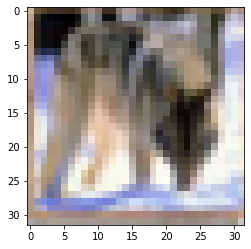

70


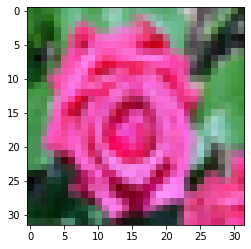

53


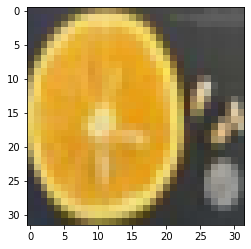

In [ ]:
for i in range(20):
  plt.figure()
  plt.imshow(x_test[i])
  print(y_test[i])
  plt.show()

# Conclusión

Como conclusión, obtener una alta precisión de clasificación en CIFAR-100 es una tarea desafiante porque hay muchas clases, pero la cantidad de muestras de capacitación para cada clase es muy pequeña. En particular, el conjunto de datos comprende solo 50000 imágenes de entrenamiento y 500 imágenes de prueba por clase.

Este código presentado es con el que obtuvimos la mejor accuracy. Notamos que el score es relativamente bajo; sin embargo probamos con todas las alternativas que encontramos de transfer learning. Probamos con:

- vgg 19 (leimos que era la mas efectiva)
- efficientNetB0 
- ResNet50
- ResNet101
- Resnet110
- ResNet 152
- vgg16
- Armando 5 capas de pooling y convolucion 2D a mano
- Usando los modelos de transfer learning sin modificar ninguna capa, y luego modificando las ultimas. Ademas probamos agregando capas nuevas
- Utilizando data augmentation y sin data augmentation a ver como variaba
- Variando el epoch y el batch size